# SENTI-PRED: Pipeline Completo de Analise de Sentimentos
## Autor: Pedro Morato Lahoz
## Data: Outubro 2025

---

### Indice:
1. [Configuracao Inicial](#config)
2. [Analise Exploratoria (EDA)](#eda)
3. [Pre-processamento](#preprocessing)
4. [Modelagem](#modeling)
5. [Avaliacao](#evaluation)
6. [Deploy com Docker](#deploy)

---
## 1. Configuracao Inicial <a id='config'></a>

In [2]:
# Importacoes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sys
import joblib
import warnings
warnings.filterwarnings('ignore')

# ML imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Configuracoes visuais
plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline

print("[OK] Bibliotecas importadas com sucesso!")

[OK] Bibliotecas importadas com sucesso!


In [3]:
# Download recursos NLTK
recursos = ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'rslp']
for recurso in recursos:
    nltk.download(recurso, quiet=True)

print("[OK] Recursos NLTK baixados!")

[OK] Recursos NLTK baixados!


In [7]:
# Configurar caminhos
DATA_RAW = '../data/raw/test.csv'
DATA_PROCESSED = '../data/processed/processed_data.csv'
MODEL_PATH = '../src/models/sentiment_model.pkl'

# Criar diretorios se nao existirem
os.makedirs(os.path.dirname(DATA_PROCESSED), exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs('../reports/visualizacoes', exist_ok=True)

print("[OK] Estrutura de diretorios configurada!")

[OK] Estrutura de diretorios configurada!


---
## 2. Analise Exploratoria de Dados (EDA) <a id='eda'></a>

In [8]:
# Carregar dados
print("Carregando dados...")
df = pd.read_csv(DATA_RAW)
print(f"[OK] Dados carregados: {df.shape[0]} registros e {df.shape[1]} colunas")

# Exibir primeiras linhas
print("\nPrimeiras linhas do dataset:")
display(df.head())

# Informações básicas
print("\nInformações do dataset:")
df.info()

# Estatísticas descritivas
print("\nEstatísticas descritivas:")
display(df.describe(include='all'))

# Verificar valores nulos
print("\nValores nulos por coluna:")
display(df.isnull().sum())

Carregando dados...
[OK] Dados carregados: 2728 registros e 3 colunas

Primeiras linhas do dataset:


,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2728 entries, 0 to 2727
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Text_ID              2728 non-null   int64 
 1   Product_Description  2728 non-null   object
 2   Product_Type         2728 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 64.1+ KB

Estatísticas descritivas:


,Text_ID,Product_Description,Product_Type
count,2728.000000,2728,2728.000000
unique,NaN,2724,NaN
top,NaN,RT @mention Marissa Mayer: Google Will Connect...,NaN
freq,NaN,3,NaN
mean,4494.328812,NaN,7.462610
std,2632.858652,NaN,2.439904
min,0.000000,NaN,0.000000
25%,2218.500000,NaN,6.000000
50%,4459.000000,NaN,9.000000
75%,6777.750000,NaN,9.000000



Valores nulos por coluna:


Text_ID                0
Product_Description    0
Product_Type           0
dtype: int64


Distribuição de classes (coluna Product_Type):


Product_Type
9    1731
6     281
2     196
7     143
3     130
8     103
5      80
0      26
1      22
4      16
Name: count, dtype: int64

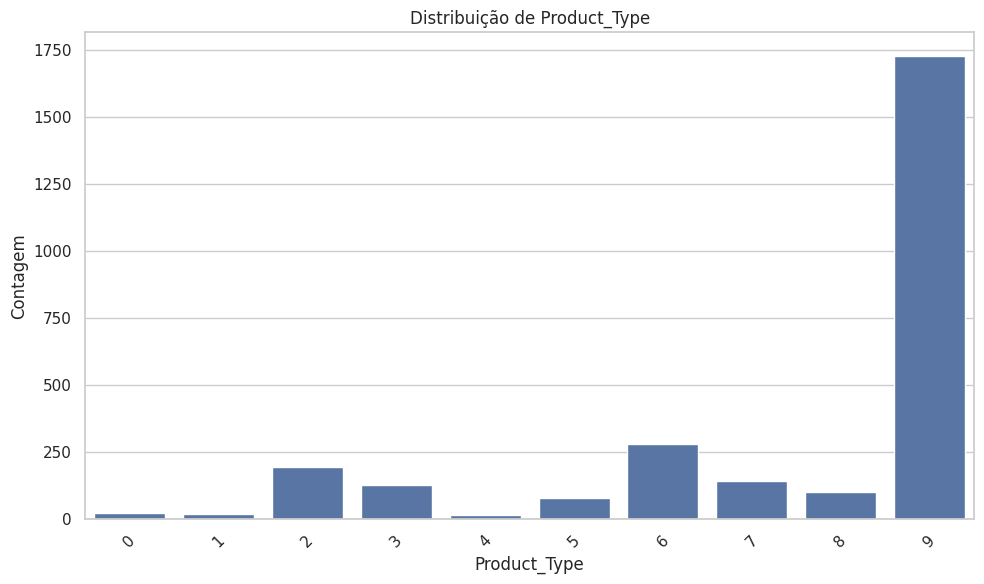

In [9]:
# Distribuição de classes (assumindo que a coluna de sentimento é 'sentiment')
if 'sentiment' in df.columns:
    print("\nDistribuição de classes:")
    sentiment_counts = df['sentiment'].value_counts()
    display(sentiment_counts)
    
    # Visualizar distribuição
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', data=df)
    plt.title('Distribuição de Sentimentos')
    plt.xlabel('Sentimento')
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    # Se não houver coluna 'sentiment', assumir que a última coluna é a target
    target_col = df.columns[-1]
    print(f"\nDistribuição de classes (coluna {target_col}):")
    target_counts = df[target_col].value_counts()
    display(target_counts)
    
    # Visualizar distribuição
    plt.figure(figsize=(10, 6))
    sns.countplot(x=target_col, data=df)
    plt.title(f'Distribuição de {target_col}')
    plt.xlabel(target_col)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Análise de comprimento de texto:
Comprimento médio: 1.00 palavras
Comprimento mínimo: 1 palavras
Comprimento máximo: 1 palavras


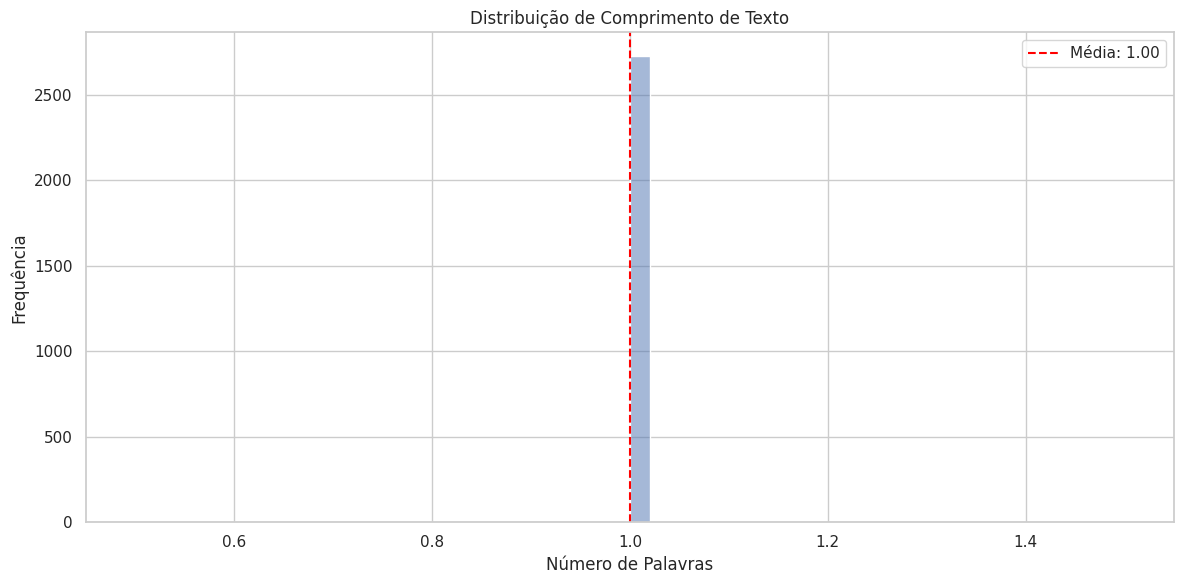

In [10]:
# Análise de comprimento de texto
print("\nAnálise de comprimento de texto:")
# Identificar a coluna de texto (assumindo que é a primeira coluna ou se chama 'text')
text_col = 'text' if 'text' in df.columns else df.columns[0]

df['text_length'] = df[text_col].apply(lambda x: len(str(x).split()))
print(f"Comprimento médio: {df['text_length'].mean():.2f} palavras")
print(f"Comprimento mínimo: {df['text_length'].min()} palavras")
print(f"Comprimento máximo: {df['text_length'].max()} palavras")

# Visualizar distribuição de comprimento
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribuição de Comprimento de Texto')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Média: {df["text_length"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/visualizacoes/text_lenght.png')
plt.show()


Palavras mais comuns:
5786    1
5363    1
6716    1
4339    1
66      1
8373    1
4264    1
1982    1
2258    1
8828    1
3156    1
5051    1
1484    1
2719    1
1491    1
4059    1
6192    1
940     1
0       1
3128    1
Name: count, dtype: int64


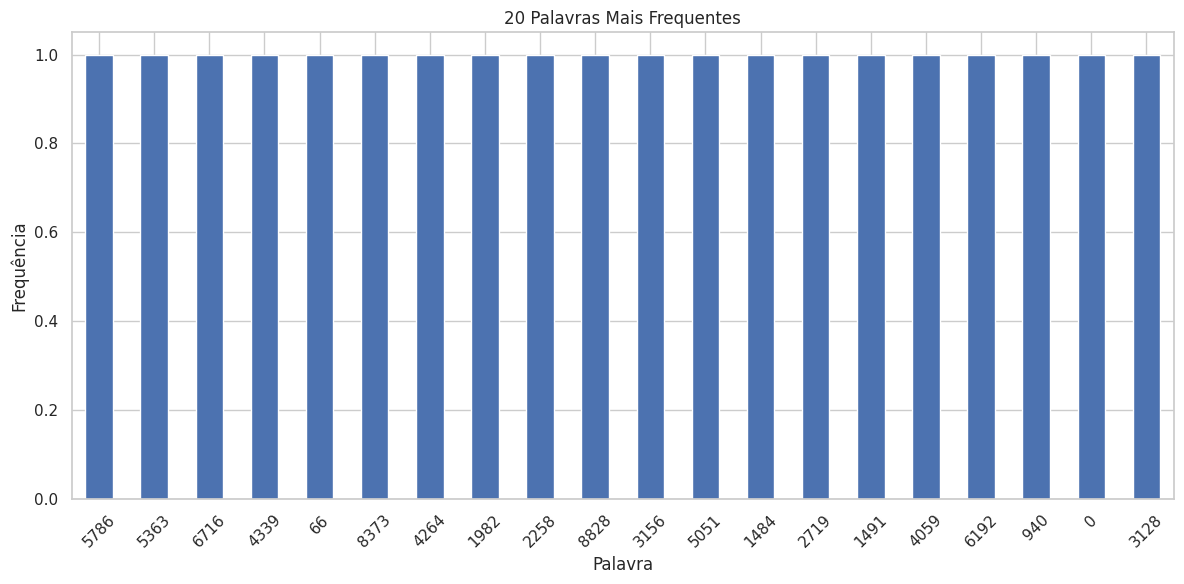

[OK] Análise exploratória concluída!


In [11]:
# Palavras mais comuns
print("\nPalavras mais comuns:")
all_words = ' '.join(df[text_col].astype(str)).lower().split()
word_counts = pd.Series(all_words).value_counts()
print(word_counts.head(20))

# Visualizar palavras mais comuns
plt.figure(figsize=(12, 6))
word_counts[:20].plot(kind='bar')
plt.title('20 Palavras Mais Frequentes')
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/visualizacoes/number_words.png')
plt.show()

print("[OK] Análise exploratória concluída!")

---
## 3. Pre-processamento <a id='preprocessing'></a>

In [12]:
# Definir funções de pré-processamento
def clean_text(text):
    """
    Limpa o texto removendo URLs, menções, pontuações e números
    """
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    """
    Remove stopwords do texto
    """
    if not isinstance(text, str):
        return ''
    stop_words = set(stopwords.words('portuguese'))
    tokens = word_tokenize(text, language='portuguese')
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

def lemmatize_text(text):
    """
    Lematiza o texto
    """
    if not isinstance(text, str):
        return ''
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text, language='portuguese')
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

print("[OK] Funções de pré-processamento definidas!")

[OK] Funções de pré-processamento definidas!


In [13]:
# Aplicar pré-processamento
print("Aplicando pré-processamento...")

# Identificar colunas
text_col = 'text' if 'text' in df.columns else df.columns[0]
target_col = 'sentiment' if 'sentiment' in df.columns else df.columns[-1]

# Criar cópia para processamento
df_processed = df.copy()

# Aplicar etapas de pré-processamento
print("1. Limpando textos...")
df_processed['text_clean'] = df_processed[text_col].apply(clean_text)

print("2. Removendo stopwords...")
df_processed['text_no_stop'] = df_processed['text_clean'].apply(remove_stopwords)

print("3. Lematizando textos...")
df_processed['text_lemmatized'] = df_processed['text_no_stop'].apply(lemmatize_text)

# Exibir exemplos
print("\nExemplos de textos processados:")
examples = pd.DataFrame({
    'Original': df_processed[text_col].head(3),
    'Limpo': df_processed['text_clean'].head(3),
    'Sem Stopwords': df_processed['text_no_stop'].head(3),
    'Lematizado': df_processed['text_lemmatized'].head(3)
})
display(examples)

# Salvar dados processados
df_processed.to_csv(DATA_PROCESSED, index=False)
print(f"[OK] Dados processados salvos em: {DATA_PROCESSED}")

Aplicando pré-processamento...
1. Limpando textos...
2. Removendo stopwords...
3. Lematizando textos...

Exemplos de textos processados:


,Original,Limpo,Sem Stopwords,Lematizado
0,5786,,,
1,5363,,,
2,6716,,,


[OK] Dados processados salvos em: ../data/processed/processed_data.csv


---
## 4. Modelagem <a id='modeling'></a>

In [14]:
# Preparar dados para modelagem
print("Preparando dados para modelagem...")

# Definir features e target
X = df_processed['text_lemmatized']
y = df_processed[target_col]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dados de treino: {X_train.shape[0]} amostras")
print(f"Dados de teste: {X_test.shape[0]} amostras")

# Verificar distribuição nos conjuntos
print("\nDistribuição de classes:")
print(f"Treino:\n{y_train.value_counts(normalize=True)}")
print(f"\nTeste:\n{y_test.value_counts(normalize=True)}")

Preparando dados para modelagem...
Dados de treino: 2182 amostras
Dados de teste: 546 amostras

Distribuição de classes:
Treino:
text_length
1    1.0
Name: proportion, dtype: float64

Teste:
text_length
1    1.0
Name: proportion, dtype: float64


In [15]:
# Definir e treinar modelos
print("\n" + "="*60)
print("TREINAMENTO DE MODELOS")
print("="*60)

# Definir modelos a serem testados
models_config = {
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dicionário para armazenar resultados
models = {}

# Treinar e avaliar cada modelo
for name, model in models_config.items():
    print(f"\nTreinando {name}...")
    
    # Criar pipeline com vetorização TF-IDF
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('model', model)
    ])
    
    # Treinar
    pipeline.fit(X_train, y_train)
    
    # Predizer
    y_pred = pipeline.predict(X_test)
    
    # Avaliar
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Relatório de classificação:\n{report}")
    
    # Armazenar modelo
    models[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred
    }

print("\n[OK] Treinamento de modelos concluído!")


TREINAMENTO DE MODELOS

Treinando Regressão Logística...


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# Comparar modelos
print("\n" + "="*60)
print("COMPARAÇÃO DE MODELOS")
print("="*60)

# Extrair acurácias
accuracies = {name: info['accuracy'] for name, info in models.items()}
print("Acurácias:")
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")

# Visualizar comparação
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Comparação de Acurácia entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/visualizacoes/models_comparasion.png')
plt.show()

# Identificar melhor modelo
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]['pipeline']
print(f"\nMelhor modelo: {best_model_name} com acurácia de {accuracies[best_model_name]:.4f}")

# Salvar melhor modelo
joblib.dump(best_model, MODEL_PATH)
print(f"[OK] Melhor modelo salvo em: {MODEL_PATH}")

---
## 5. Avaliacao <a id='evaluation'></a>

In [ ]:
# Avaliação detalhada do melhor modelo
print("\n" + "="*60)
print(f"AVALIAÇÃO DETALHADA: {best_model_name}")
print("="*60)

# Obter predições
y_pred = models[best_model_name]['predictions']

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.savefig(f'../reports/visualizacoes/{best_model_name.lower().replace(" ", "-")}_matriz.png')
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Verificar se o modelo suporta predict_proba
if hasattr(best_model, 'predict_proba'):
    # Curva ROC (para problemas binários)
    if len(np.unique(y)) == 2:
        y_prob = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
        
        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Curva Precision-Recall')
        plt.tight_layout()
        plt.savefig('../reports/visualizacoes/precision.png')
        plt.show()

print("\n[OK] Avaliação detalhada concluída!")

In [ ]:
# Teste com exemplos reais
print("\n" + "="*60)
print("TESTE COM EXEMPLOS REAIS")
print("="*60)

# Carregar modelo
loaded_model = joblib.load(MODEL_PATH)

# Exemplos de textos para teste
exemplos = [
    "Adorei o produto, superou minhas expectativas!",
    "Produto de péssima qualidade, não recomendo.",
    "Entrega rápida, mas o produto veio com defeito.",
    "Atendimento ao cliente excelente, resolveram meu problema rapidamente."
]

# Processar exemplos
exemplos_processados = []
for texto in exemplos:
    texto_limpo = clean_text(texto)
    texto_sem_stop = remove_stopwords(texto_limpo)
    texto_lemmatizado = lemmatize_text(texto_sem_stop)
    exemplos_processados.append(texto_lemmatizado)

# Predizer
predicoes = loaded_model.predict(exemplos_processados)

# Exibir resultados
print("\nResultados:")
for i, (texto, pred) in enumerate(zip(exemplos, predicoes)):
    print(f"Exemplo {i+1}: {texto}")
    print(f"Predição: {pred}\n")

print("\n[OK] Teste com exemplos reais concluído!")

---
## 6. Deploy com Docker <a id='deploy'></a>

In [ ]:
# Criar arquivo Dockerfile para API
dockerfile_content = '''
FROM python:3.9-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY . .

EXPOSE 8000

CMD ["python", "manage.py", "runserver", "0.0.0.0:8000"]
'''

# Escrever Dockerfile
with open('../src/api/Dockerfile', 'w') as f:
    f.write(dockerfile_content)

print("[OK] Dockerfile criado em: ../src/api/Dockerfile")

In [ ]:
# Criar arquivo docker-compose.yml
docker_compose_content = '''
version: '3'

services:
  api:
    build:
      context: .
      dockerfile: ./src/api/Dockerfile
    ports:
      - "8000:8000"
    volumes:
      - ./:/app
    environment:
      - DEBUG=True
'''

# Escrever docker-compose.yml
with open('../docker-compose.yml', 'w') as f:
    f.write(docker_compose_content)

print("[OK] docker-compose.yml criado em: ../docker-compose.yml")

In [ ]:
# Criar arquivo de views para API
views_content = '''
import joblib
import os
from django.http import JsonResponse
from django.views.decorators.csrf import csrf_exempt
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Carregar modelo
MODEL_PATH = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(__file__))), 'src', 'models', 'sentiment_model.pkl')
model = joblib.load(MODEL_PATH)

# Baixar recursos NLTK
recursos = ['punkt', 'stopwords', 'wordnet', 'punkt_tab', 'rslp']
for recurso in recursos:
    nltk.download(recurso, quiet=True)

# Funções de pré-processamento
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    if not isinstance(text, str):
        return ''
    stop_words = set(stopwords.words('portuguese'))
    tokens = word_tokenize(text, language='portuguese')
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

def lemmatize_text(text):
    if not isinstance(text, str):
        return ''
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text, language='portuguese')
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

def preprocess_text(text):
    text_clean = clean_text(text)
    text_no_stop = remove_stopwords(text_clean)
    text_lemmatized = lemmatize_text(text_no_stop)
    return text_lemmatized

@csrf_exempt
def predict_sentiment(request):
    if request.method == 'POST':
        try:
            data = json.loads(request.body)
            text = data.get('text', '')
            
            # Pré-processar texto
            processed_text = preprocess_text(text)
            
            # Predizer sentimento
            prediction = model.predict([processed_text])[0]
            
            # Retornar resultado
            return JsonResponse({
                'text': text,
                'sentiment': prediction,
                'success': True
            })
        except Exception as e:
            return JsonResponse({
                'error': str(e),
                'success': False
            }, status=400)
    
    return JsonResponse({
        'error': 'Método não permitido',
        'success': False
    }, status=405)
'''

# Escrever views.py
with open('../src/api/views.py', 'w') as f:
    f.write(views_content)

print("[OK] views.py criado em: ../src/api/views.py")

In [ ]:
# Criar arquivo de URLs para API
urls_content = '''
from django.urls import path
from .views import predict_sentiment

urlpatterns = [
    path('predict/', predict_sentiment, name='predict_sentiment'),
]
'''

# Escrever urls.py
with open('../src/api/urls.py', 'w') as f:
    f.write(urls_content)

print("[OK] urls.py criado em: ../src/api/urls.py")

In [ ]:
# Criar arquivo README.md
readme_content = '''
# SENTI-PRED: Análise de Sentimentos

## Descrição
Sistema de análise de sentimentos para textos em português, utilizando técnicas de processamento de linguagem natural e aprendizado de máquina.

## Estrutura do Projeto
```
├── data/
│   ├── processed/       # Dados processados
│   └── raw/             # Dados brutos
├── notebooks/           # Jupyter notebooks
├── reports/             # Relatórios e visualizações
│   └── visualizacoes/   # Gráficos e visualizações
├── src/                 # Código fonte
│   ├── api/             # API para deploy
│   ├── models/          # Modelos treinados
│   └── scripts/         # Scripts de processamento
├── tests/               # Testes
├── docker-compose.yml   # Configuração Docker Compose
└── README.md            # Este arquivo
```

## Instalação
1. Clone o repositório
2. Instale as dependências: `pip install -r requirements.txt`
3. Execute o notebook `notebooks/full_pipeline.ipynb` para treinar o modelo

## Deploy com Docker
```bash
docker-compose up -d
```

## API
Endpoint: `/api/predict/`

Exemplo de requisição:
```json
{
    "text": "Adorei o produto, superou minhas expectativas!"
}
```

Exemplo de resposta:
```json
{
    "text": "Adorei o produto, superou minhas expectativas!",
    "sentiment": "positivo",
    "success": true
}
```
'''

# Escrever README.md
with open('../README.md', 'w') as f:
    f.write(readme_content)

print("[OK] README.md criado em: ../README.md")

In [ ]:
print("\n" + "="*60)
print("PIPELINE COMPLETO FINALIZADO")
print("="*60)
print("\nO pipeline de análise de sentimentos foi concluído com sucesso!")
print("\nArquivos gerados:")
print(f"- Dados processados: {DATA_PROCESSED}")
print(f"- Modelo treinado: {MODEL_PATH}")
print("- Visualizações: ../reports/visualizacoes/")
print("- Arquivos para deploy: ../src/api/")
print("\nPara iniciar a API, execute: docker-compose up -d")